# **Estimating corneal endothelium parameters with CNNs (TVST paper)**




This notebook is based on the paper: 
> Vigueras-Guillén *et al.* (2020). Deep learning for assessing the corneal endothelium from specular microscopy images up to one year after ultrathin-DSAEK surgery. ***Translational Vision Science & Technology***. 2020; 9(2):49, https://doi.org/10.1167/tvst.9.2.49

The aformentioned paper presents a deep learning approach to estimate the corneal endothelium parameters from post ultrathin Descemet stripping automated endothelial keratoplasty (UT-DSAEK) images. The manuscript contains:

*   A technical analysis of the methodology (error analysis).
*   A clinical analysis regarding the progression of the parameters during the one-year follow-up after surgery.



**Data**: 383 images from 41 patients, imaged at 1, 3, 6 and 12 months after UT-DSAEK surgery. Acquired in the *The Rotterdam Eye Hospital* (Rotterdam, The Netherlands).

**Secondary dataset for assisting the training**: 400 images, glaucoma patients. Also acquired in the *The Rotterdam Eye Hospital* (Rotterdam, The Netherlands).

All images were manually annotated (delinitation of the cell edges) to estimate the Gold Standard parameters. The corneal parameters are:


*   Endothelial cell density (ECD), defined as the number of cells per mm<sup>2</sup>.
*   Coefficient of variation (CV), defined as the ratio of the standard deviation (SD) of the cell size to its mean size, in percentage.
*   Hexagonality (HEX), defined as the percentage of six-sided cells.


Here, we will briefly illustrate the deep learning methodology. More detailed explanations of each one of the DL parts can be found in our previous publications (see references at the end of the notebook). ***Please, cite our papers if you make use of this code.***



### **Due to regulatory restrictions, we cannot make the data open-access at this moment.**
Nonetheless, this notebook was saved with the outcome of the cells in order to illustrate the methodology.

## Import packages

First and foremost, import the required packages.

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt   # To plot figures
import imageio as imageio         # To read images

This notebook was prepared for Google Colaboratory, and images and weights were loaded from Google Drive. To mount Drive, run the cell below. Here, the notebook was saved within the folder: 'drive/My Drive/Colab Notebooks/TVST_paper/'
 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_folder = 'drive/My Drive/Colab Notebooks/TVST_paper/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Introduction**

The aim of this notebook is to show the framework described in the TVST manuscript to segment [specular microscopy](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3062434/) images of the [corneal endothelium](https://en.wikipedia.org/wiki/Corneal_endothelium) and infer the clinical parameters of the cornea: cell density (ECD), coefficient of variation (CV), and hexagonality (HEX). 

Briefly, the corneal endothelium is the posterior layer of the cornea, comprised of pseudo-hexagonal cells with barely any extracelular matrix, which controls the [hydration of the cornea](https://www.nature.com/articles/6700559). The endothelium cell density decreases naturally over time (from approx. 2800-3000 cells/mm<sup>2</sup> in a healthy young adult to 2200-2600 cells/mm<sup>2</sup> in the healthy elderly) and they lack regeneration. If cell loss accelarates due to trauma, surgical intervention, or certain diseases, the remaining healthy cells increase in size and lose their rather hexagonal shape in order to cover the space of the lost cells and maintain the barrier properties. If the cell density decreases below 700 cells/mm<sup>2</sup>, [corneal edema](https://www.healthline.com/health/corneal-edema) might appear, which affects the vision. In the worst case, a corneal transplant would be necessary. Therefore, it is clinically relevant to estimate the corneal parameters to assess the healthy status of the cornea. 

In this regard, specular microscopy allows to image the endothelium in a non-invasive manner, but the quallity of the images is rather limited. Furthermore, it is very complex to automatically identify and segment the cells in pathological or post-surgical corneas due to the many optical distortions that can appear.

## **2. The framework**


This notebook will only perform the testing phase of the CNNs. For this, it will load the weights of the CNNs (stored in the subfolder 'weights').

Here, six images with different qualities will be tested in order **to show the challenges of the problem and the performance of our method** (the whole dataset employed in the TVST paper, 883 images, will probably become public in the future).

The framework is comprised of three parts:
*   The intensity image, provided by the specular microscopy (gray-scale, 240x528 px), is given as input to the CNN-Edge to produce the edge (probability) image [1,2]. CNN-Edge is based on Dense U-nets (see below).
*   The edge image is then given as input to the CNN-ROI to identify the areas (in the edge image) where cells were correctly detected [1,3]. (ROI means Region of Interest). The same network architecture as CNN-Edge is used.
*   The edge and ROI images are provided to a post-processing method, which generates the final binary image from where the corneal parameters are estimated [1,4,5,6]. This part was originally implemented in Matlab (**to be included here -in Python- in future versions!**)

Please, refer to the TVST paper for further details.

(-0.5, 1599.5, 368.5, -0.5)

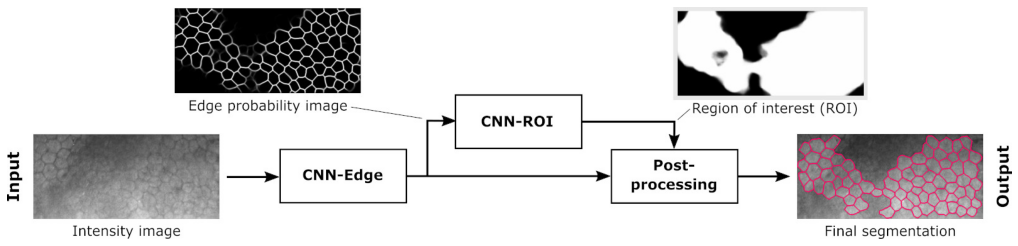

In [ ]:
# Print the framework 
nam_framework = data_folder + 'figures/Framework_CNNs_(TVST_figure).jpg'
fig_framework = imageio.imread(nam_framework).astype(np.uint8)
plt.figure(figsize=(18,10))
plt.imshow(fig_framework)
plt.axis('off')

<small>Overview diagram of the fully-automatic method. </small>

*Figure from the TVST paper - Copyright reserved.*

## **3. The network code**

Define the arguments of the problem:

In [ ]:
# Create a Namespace with all the arguments 
from argparse import Namespace
args = Namespace()
args.image_shape = (528, 240, 1)   
args.data_format = 'channels_last' 

# The network
args.classes = (0, 1)
args.growth_rate = 8
args.blocks = (6, 12, 24, 48, 24, 12, 6)
args.lr = 0.001
args.lr_decay = 0.99  

# Folder to the weights:
args.edge_weights = data_folder + 'weights/weights_edges_epoch150.h5'
args.roi_weights  = data_folder + 'weights/weights_ROI_epoch150.h5'

For informative purpose, both CNNs models were trained with 150 epochs, and they showed a robust training with no overfitting. This is the training accuracy graph for CNN-Edge:

(-0.5, 1999.5, 999.5, -0.5)

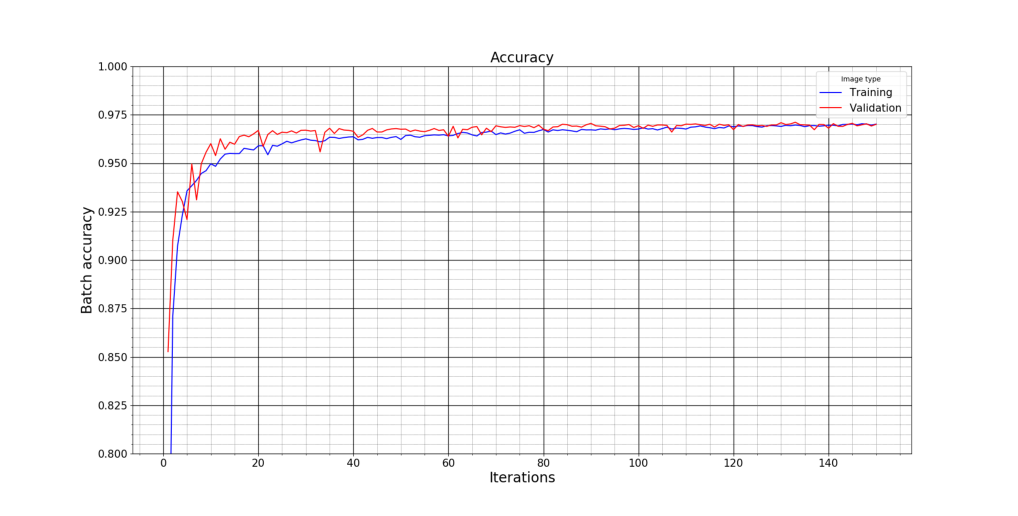

In [ ]:
# Print the training accuracy 
fig_acc = data_folder + 'figures/Fig01_Edges_accuracy.png'
fig_acc = imageio.imread(fig_acc).astype(np.uint8)
plt.figure(figsize=(18,10))
plt.imshow(fig_acc)
plt.axis('off')

**Load the CNN-Edge and CNN-ROI with their weights:**

In [ ]:
%tensorflow_version 2.x

import tensorflow.keras.layers as layers 
import tensorflow.keras.backend as K 
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam, Nadam

K.clear_session()  # For easy reset of notebook state.
   

##############################################################################
#  BLOCKS
##############################################################################

def dense_block(x, blocks, growth_rate, name, data_format='channels_last'):
    """A dense block.
    # Arguments
        x:          input tensor.
        blocks:     integer, the number of building blocks.
        growth_rate: float, growth rate at dense layers (output maps).
        name:       string, block label.
    # Returns
        output tensor for the block.
    """
    for i in range(blocks):
      x = conv_block(x, growth_rate, name=name + '_block' + str(i + 1), 
                     data_format=data_format)
    return x



def conv_block(x, growth_rate, name, data_format='channels_last'):
    """ A building block for a dense block.
    # Arguments
        x:          input tensor.
        growth_rate: float, growth rate at dense layers.
        name:       string, block label.
    # Returns
        Output tensor for the block.
    """
    bn_axis = 1 if data_format=='channels_first' else 3
    x1 = layers.Conv2D(growth_rate, 4, activation=None, padding='same',  
                       use_bias=False, data_format=data_format, 
                       name=name + '_conv')(x)
    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                   renorm=True, name=name + '_bn')(x1)  
    x1 = layers.Activation('elu')(x1)
    x1 = layers.Dropout(rate=0.2, name=name + '_drop')(x1)
    x  = layers.Concatenate(axis=bn_axis, name=name + '_conc')([x,x1])    
    return x



def down_block(x, out_channels, name, data_format='channels_last'):
    """ The downsampling block, which contains a feature reduction layer, 
    (Conv1x1) + BRN + ELU, and a average pooling layer.
    # Arguments
        x:            input tensor.
        out_channels: float, number of output channels.
        name:         string, block label.
    # Returns
        Output tensor for the block.
    """
    bn_axis = 1 if data_format=='channels_first' else 3
    x = layers.Conv2D(out_channels, 1, activation=None, padding='same',  
                      use_bias=False, data_format=data_format, 
                      name=name + '_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  renorm=True, name=name + '_bn')(x)  
    x = layers.Activation('elu')(x)
    x = layers.AveragePooling2D(2, padding='same', 
                                data_format=data_format)(x)  
    return x


def upsampling_block(x, out_channels, name, data_format='channels_last'):
    """ The upsampling block, which contains a transpose convolution.
    # Arguments
        x:            input tensor.
        out_channels: float, number of output channels.
        name:         string, block label.
    # Returns
        Output tensor for the block.
    """
    bn_axis = 1 if data_format=='channels_first' else 3
    x = layers.Conv2DTranspose(out_channels, 4, strides=(2, 2), 
                               activation=None, padding='same',  
                               use_bias=False, data_format=data_format, 
                               name=name + '_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  renorm=True, name=name + '_bn')(x) 
    x = layers.Activation('elu')(x)
    return x


##############################################################################
# CORE OF THE NETWORK
##############################################################################

def get_unet(image_shape, blocks, growth_rate, lr, weights=None,
             data_format='channels_last'):
    """ The core of the Dense U-Net.
    # Arguments
        image_shape:  array, ints, shape of the image.
        blocks:       array, ints, the number of dense blocks for each 
                      resolution block.
        growth_rate:  float, growth rate (feature maps) at the dense layers.
        lr:           float, learning rate of the optimizer.
        weights:      string, name of the h5 file with the weights (optional)
        data_format:  string to indicate whether channels go first or last. 
                      NOTE: The code only works with channels_last for now.
    # Returns the model
    """

    bn_axis = 1 if data_format=='channels_first' else 3
    comprs = [int(x*growth_rate*0.50) for x in blocks]

    inputs = layers.Input(shape=image_shape)
    
    #-------------------------------------------- Dense Block 01    
    x1  = dense_block(inputs, blocks[0], growth_rate, name='block_1', 
                      data_format=data_format)    
    x1d = down_block(x1, comprs[0], name='down_1', 
                     data_format=data_format)   
    
    #-------------------------------------------- Dense Block 02
    x2i = layers.AveragePooling2D(2, padding='same',
                                  data_format=data_format)(inputs)
    x2c = layers.Concatenate(axis=bn_axis)([x2i,x1d])
    x2  = dense_block(x2c, blocks[1], growth_rate, name='block_2', 
                      data_format=data_format)   
    x2d = down_block(x2, comprs[1], name='down_2', 
                     data_format=data_format)   
    
    #-------------------------------------------- Dense Block 03
    x3i = layers.AveragePooling2D(2, padding='same', 
                                  data_format=data_format)(x2i)
    x3c = layers.Concatenate(axis=bn_axis)([x3i,x2d])   
    x3  = dense_block(x3c, blocks[2], growth_rate, name='block_3', 
                      data_format=data_format)    
    x3d = down_block(x3, comprs[2], name='down_3', 
                     data_format=data_format)   					  
    
    #-------------------------------------------- Dense Block 04
    x4i = layers.AveragePooling2D(2, padding='same', 
                                  data_format=data_format)(x3i)
    x4c = layers.Concatenate(axis=bn_axis)([x4i,x3d])
    x4  = dense_block(x4c, blocks[3], growth_rate, name='block_4', 
                      data_format=data_format)  
    up4 = upsampling_block(x4, comprs[3], name='up_4', 
                           data_format=data_format) 

    #-------------------------------------------- Dense Block 05
    x5  = layers.Concatenate(axis=bn_axis)([x3,up4])
    x5  = dense_block(x5, blocks[4], growth_rate, name='block_5', 
                      data_format=data_format)  
    up5 = upsampling_block(x5, comprs[4], name='up_5', 
                           data_format=data_format)   
      
    #-------------------------------------------- Dense Block 06
    x6  = layers.Concatenate(axis=bn_axis)([x2,up5])
    x6  = dense_block(x6, blocks[5], growth_rate, name='block_6', 
                      data_format=data_format)  
    up6 = upsampling_block(x6, comprs[5], name='up_6', 
                           data_format=data_format)  
    
    #-------------------------------------------- Dense Block 07
    x7 = layers.Concatenate(axis=bn_axis)([x1,up6])
    x7 = dense_block(x7, blocks[6], growth_rate, name='block_7', 
                     data_format=data_format)  
    x7 = layers.Conv2D(2, (1, 1), activation='elu', padding='same',
                       data_format=data_format)(x7)
   
    #-------------------------------------------- RESHAPE BLOCK  
    # This part is not yet prepared for 'channels_first'
    x8 = layers.Permute((3,1,2))(x7)  
    x8 = layers.Reshape((2, int(image_shape[0]*image_shape[1])))(x8)
    x8 = layers.Permute((2,1))(x8)
    x8 = layers.Activation('softmax')(x8)

    #-------------------------------------------- PARAMETERS
    model = Model(inputs=inputs, outputs=x8)
    nadam = Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    if weights is not None:
        model.load_weights(weights)
    model.compile(optimizer=nadam, 
                  loss= 'categorical_crossentropy', 
                  metrics=['categorical_accuracy'])    
    return model


##############################################################################
# Load the Dense U-net model for CNN-Edge
model_edge = get_unet(args.image_shape, 
                      args.blocks, 
                      growth_rate=args.growth_rate, 
                      lr=args.lr,
                      weights=args.edge_weights,
                      data_format=args.data_format)  


# Load the Dense U-net model for CNN-ROI
model_roi = get_unet(args.image_shape, 
                     args.blocks, 
                     growth_rate=args.growth_rate, 
                     lr=args.lr,
                     weights=args.roi_weights,
                     data_format=args.data_format)  

# Number of parameters in each model: 7.1M

## **4. Load the test images and run the models**

  Loading names of 6 images...


(-0.5, 239.5, 527.5, -0.5)

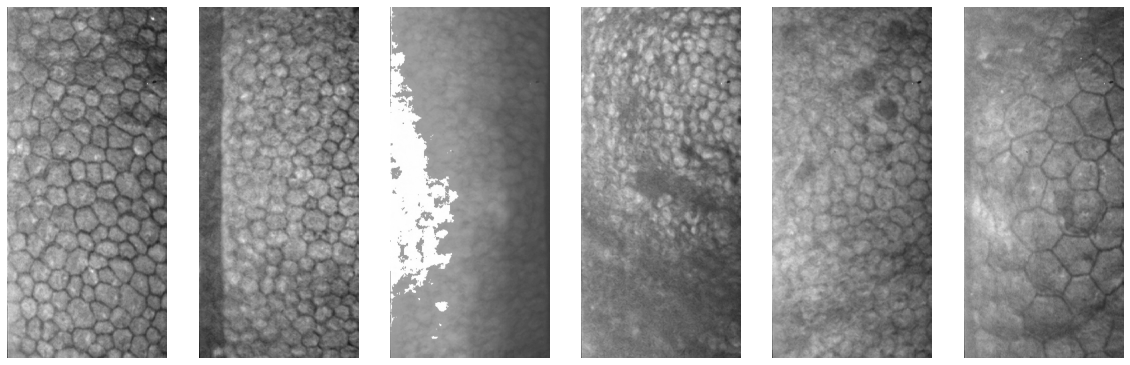

In [ ]:
# Load the intensity images

def load_image_names(folder, ending=None):
    """ It loads the names of all images from directory. If given an ending,
    only those files will be returned.	
    """
    img_files = sorted(os.listdir(folder)) 
    if ending is not None:
      img_files = [ii for ii in img_files if ii.endswith(ending)]
    img_number = len(img_files)     
    print("  Loading names of", str(img_number), "images...")   
    return np.asarray(img_files)     

intn_folder = data_folder + 'intn_images/'
intn_names = load_image_names(intn_folder)
intn_image = np.ndarray(shape=(len(intn_names), 
                               args.image_shape[0],
                               args.image_shape[1]))

for ii in range(len(intn_names)):
  a_name = intn_folder + intn_names[ii]
  intn_image[ii] = imageio.imread(a_name).astype(np.uint8)
intn_image = intn_image[:,:,:,np.newaxis]            # Add axis C.
intn_image = intn_image.astype(np.float32) / 255     # Normalize


# Plot the examples
fig, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(1, 6, figsize=(20,50))
ax1.imshow(intn_image[0,:,:,0], cmap="gray", vmin=0, vmax=1); ax1.axis('off')
ax2.imshow(intn_image[1,:,:,0], cmap="gray", vmin=0, vmax=1); ax2.axis('off')
ax3.imshow(intn_image[2,:,:,0], cmap="gray", vmin=0, vmax=1); ax3.axis('off')
ax4.imshow(intn_image[3,:,:,0], cmap="gray", vmin=0, vmax=1); ax4.axis('off')
ax5.imshow(intn_image[4,:,:,0], cmap="gray", vmin=0, vmax=1); ax5.axis('off')
ax6.imshow(intn_image[5,:,:,0], cmap="gray", vmin=0, vmax=1); ax6.axis('off')

As displayed above, the image quality differs substantially, from images with good contrast (leftmost) to images with different type of artifacts or presence of guttae. Overall, it is common to obtain images with many areas out of focus in pathological corneas.

(-0.5, 239.5, 527.5, -0.5)

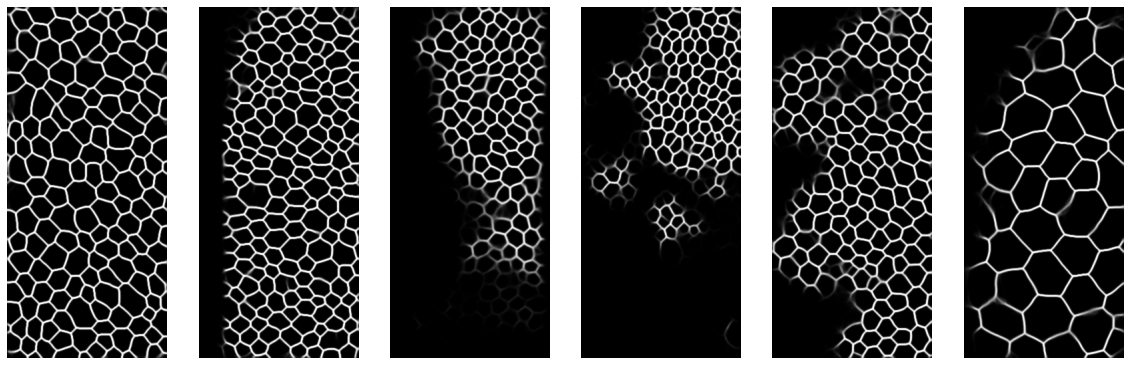

In [ ]:
# Run the CNN-Edge
edge_image = model_edge.predict_on_batch(intn_image)  
edge_image = edge_image[:,:,1]
edge_image = np.reshape(edge_image, (intn_image.shape[0], 
                                     args.image_shape[0], 
                                     args.image_shape[1]))


# Plot the examples
fig, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(1, 6, figsize=(20,50))
ax1.imshow(edge_image[0], cmap="gray", vmin=0, vmax=1); ax1.axis('off')
ax2.imshow(edge_image[1], cmap="gray", vmin=0, vmax=1); ax2.axis('off')
ax3.imshow(edge_image[2], cmap="gray", vmin=0, vmax=1); ax3.axis('off')
ax4.imshow(edge_image[3], cmap="gray", vmin=0, vmax=1); ax4.axis('off')
ax5.imshow(edge_image[4], cmap="gray", vmin=0, vmax=1); ax5.axis('off')
ax6.imshow(edge_image[5], cmap="gray", vmin=0, vmax=1); ax6.axis('off')

The CNN-Edge can detect the cell edges with very high accuracy, regardless of the properties of the cells (large or small cell size, or with large/small cell size variation). In fact, it can infer edges in areas where it is difficult for us, humans, to analyze.

Importantly, it is clear that **when non-trustworthy areas are surrounded by cells** (5th image) or **several small areas with cells are detected** (4th image), it is necessary to implement a method that automatically discard the non-trustworthy areas. If only the non-ROI were in the outer-part of the image (as in 2nd, 3rd, and 6th image), it would be straight-forward to remove them.


(-0.5, 239.5, 527.5, -0.5)

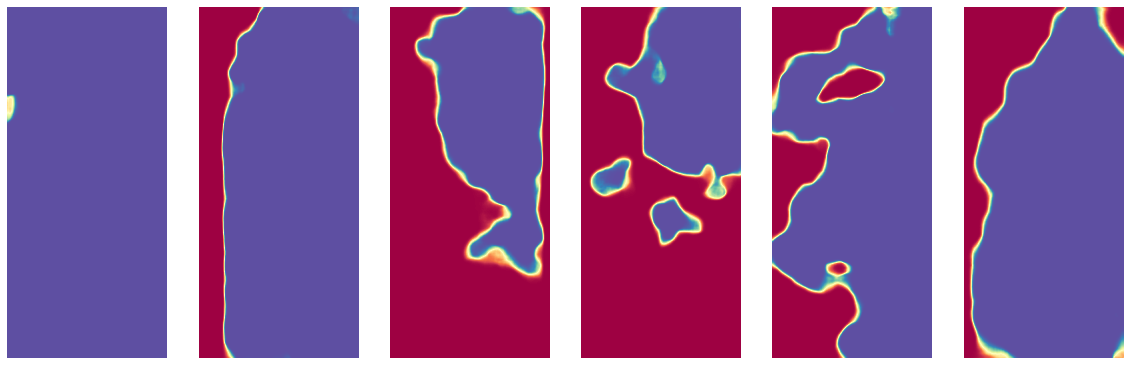

In [ ]:
# Run the CNN-ROI
roi_input = edge_image[:,:,:,np.newaxis]   # Prepare image for input

roi_image = model_roi.predict_on_batch(roi_input)  
roi_image = roi_image[:,:,1]
roi_image = np.reshape(roi_image, (roi_input.shape[0], 
                                   args.image_shape[0], 
                                   args.image_shape[1]))



# Plot the CNN-Edge output (plot in two ways to highlight the differences)
fig, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(1, 6, figsize=(20,50))
ax1.imshow(roi_image[0], cmap="Spectral", vmin=0, vmax=1); ax1.axis('off')
ax2.imshow(roi_image[1], cmap="Spectral", vmin=0, vmax=1); ax2.axis('off')
ax3.imshow(roi_image[2], cmap="Spectral", vmin=0, vmax=1); ax3.axis('off')
ax4.imshow(roi_image[3], cmap="Spectral", vmin=0, vmax=1); ax4.axis('off')
ax5.imshow(roi_image[4], cmap="Spectral", vmin=0, vmax=1); ax5.axis('off')
ax6.imshow(roi_image[5], cmap="Spectral", vmin=0, vmax=1); ax6.axis('off')

The images have been plot with the colormap 'spectral' just to highlight the differences and how the transition between ROI and non-ROI is usually sharp. The non-trustworthy areas appear in red, whereas the trustworthy areas appear in blue.

As observed in the **3rd, 4th, and 5th image**, CNN-ROI not only detect inner non-trustworthy areas, but also areas where the edges were not infered with high certainty. 

Note that the post-processing method can actually enhance weak edges when applying the watershed algorithm, fixing this problem to certain extent (as it does in the example shown in the figure from '*2.Framework*'). Depending on the proportion of the area of a cell in the ROI and non-ROI, it will be decided to exclude it or not.

## **5. (TODO) Apply the post-processing**

Finally, the edge probabilistic images need to be converted into binary images and the non-ROI areas need to be removed. After that, the corneal parameters can be easily estimated.

This part was implemented in **Matlab**. The version in Python is in progress.
Briefly:
- The Fourier analysis of an edge_image can provide the average cell size of the image.
- That average cell size can be used to smooth the edge_images properly.
- Subsequently, we can apply the watershed algorithm to get a binary image with edges of 1-pixel width and with the certainty that no ovesegmentation will occur (very rare due to the previous two steps).
- Observe that the post-processing method does NOT require any parameter, except the scaling factor of the smoothing filter, whose value was studied in [6].
- The cells outside the ROI are removed. The cells partially inside the ROI are evaluated to consider their inclusion (75% area within the ROI are included).
- Corneal parameters are finally computed from the resulting binary image.

A detailed description and discussion of the post-processing method can be found in previous work [2,4,6]

# **References**

[1] Vigueras-Guillén JP, van Rooij J, Lemij HG, van Vliet LJ, Vermeer KA. Deep learning for assessing the corneal endothelium from specular microscopy images up to one year after ultrathin-DSAEK surgery. ***Translational Vision Science & Technology (TVST)***. 2020; 9(2):49.

[2] Vigueras-Guillén JP, Sari B, Goes SF, Lemij HG, van Rooij J, Vermeer KA, van Vliet LJ. Fully convolutional architecture vs sliding-window CNN for corneal endothelium cell segmentation. ***BMC Medical Engineering***. 2019; 1:4.

[3] Vigueras-Guillén JP, Lemij HG, van Rooij J, Vermeer KA, van Vliet LJ. Automatic detection of the region of interest in corneal endothelium images using dense convolutional neural networks. ***Proceedings of SPIE, Medical Imaging 2019***: Image Processing. San Diego, CA, USA. 2019; 10949:1094931.

[4] Vigueras-Guillén JP, van Rooij J, Lemij HG, Vermeer KA, van Vliet LJ. Convolutional neural network-based regression for biomarker estimation in corneal endothelium microscopy images. ***41st Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC)***. 2019; 876-881.

[5] Vigueras-Guillén JP, Andrinopoulou ER, Engel A, Lemij HG, van Rooij J, Vermeer KA, van Vliet LJ. Corneal endothelial cell segmentation by classifier-driven merging of oversegmented images. ***IEEE Transactions on Medical Imaging***. 2018; 37(10):2278-2289.

[6] Vigueras-Guillén JP, Engel A, Lemij HG, van Rooij J, Vermeer KA, van Vliet LJ. Improved accuracy and robustness of a corneal endothelial cell segmentation method based on merging superpixels. ***15th International Conference on Image Analysis and Recognition (ICIAR 2018), Lecture Notes in Computer Science.*** 2018; 10882:631-638.